In [1]:
import random
from collections import Counter, defaultdict
from pymongo import MongoClient
import pickle
import os
import json
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from utils import *
from sklearn.metrics.pairwise import cosine_similarity
import jieba
import re
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import cohen_kappa_score
import scipy.stats as stats
from scipy.stats import pearsonr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import Counter
import utils
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_rel
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.linear_model import LinearRegression
from itertools import combinations
import random
import os
from sklearn import metrics
from tqdm import tqdm_notebook
import re
import jieba
import json
plt.rcParams["font.family"] = "SimHei"

sns.set_context("notebook")
sns.set_style("ticks")
%matplotlib inline

In [2]:
colors = ["#CD5B4D", "#F7CE5F", "#4F9F66"]
# snscolors = ['#A93537', '#3D71AB']
blue = sns.color_palette("Blues", 5)[-2]
red = sns.color_palette("Reds", 5)[-2]

def plot_dist(dlist, vlist, label="", offset=0, color=None, hatch=None):
    cnt = Counter(dlist)
    dist_vec = np.array([cnt[t] for t in vlist], dtype=float)
    dist_vec = dist_vec / np.sum(dist_vec)
    
    plt.bar(np.arange(len(vlist))+offset, dist_vec, width=0.3, color=color, label=label)
    if hatch:
        plt.bar(np.arange(len(vlist))+offset, dist_vec, width=0.3, color="None", edgecolor='k', hatch=hatch)

    plt.legend()
    plt.xticks(np.arange(len(vlist)), vlist)
    
def plot_dist_field(dlist, vlist, label="", offset=0, color="r", colorgroup="Reds"):
    cnt = Counter(dlist)
    dist_vec = np.array([cnt[t] for t in vlist], dtype=float)
    dist_vec = dist_vec / np.sum(dist_vec)
    with sns.color_palette(colorgroup, len(vlist)) as tcolor:
        for ti, tv in enumerate(dist_vec):
            plt.bar(np.array([ti])+offset, [tv], width=1., label=str(ti+1), color=tcolor[ti])
            # print (round(tv*100,1))
            plt.text(ti + offset, tv+0.01, "{}%".format(round(tv*100,1)), horizontalalignment='center', verticalalignment='center')
    # plt.legend()
    plt.xticks(np.arange(len(vlist)), vlist)
    
def calculate_pvalues(df, fun=pearsonr):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(fun(df[r], df[c])[1], 4)
    return pvalues

def ifdiff(dlist1, dlist2, fun=ttest_ind):
    pv = ttest_ind(dlist1.dropna(), dlist2.dropna())[1]
    return pv

def stats(dlist):
    return np.mean(dlist), np.var(dlist), np.max(dlist)

def plot_heatmap(tmat, axis=0, reverse_y=True, xticks=range(1, 6), yticks=range(1, 6), vmax=None):
    # axis=0: 按列归一化; axis=1: 按行归一化
    plotmat = tmat.copy()
    if axis == 0:
        tdiv = np.sum(plotmat, axis=0)
        tdiv[tdiv == 0] = 1
        plotmat = plotmat / tdiv
    else:
        tdiv = np.sum(plotmat, axis=1).reshape((plotmat.shape[0], 1))
        tdiv[tdiv == 0] = 1
        plotmat = plotmat / tdiv

    plotmat[np.isnan(plotmat)] = 0.0
    if reverse_y:
        sns.heatmap(plotmat[::-1,:], annot=True, cmap="Blues", vmax=vmax)
        plt.yticks(np.arange(plotmat.shape[0])+0.5, yticks[::-1])
    plt.xticks(np.arange(plotmat.shape[0])+0.5, xticks)
    
def plot_change_mat(x, y, data):
    tmat = np.zeros((5, 5))
    for tv1, tv2 in zip(data[y], data[x]):
        tmat[int(tv1)-1, int(tv2)-1] += 1
    plot_heatmap(tmat, axis=0, reverse_y=True, vmax=0.7)
    plt.xlabel(x)
    plt.ylabel(y)
    
def compare(df1, df2, keys, plimit=1.0, fun=ttest_ind):
    recs = []
    anskeys = []
    for tk in keys:
        try:
            tp = ifdiff(df1[tk], df2[tk], fun=fun)
            recs.append((np.mean(df1[tk]), np.mean(df2[tk]), tp if tp <= plimit else np.nan))
            anskeys.append(tk)
        except:
            pass
    df_ans = pd.DataFrame.from_records(recs, columns=['left', 'right', 'p-value'], index=anskeys)
    return df_ans

def pcc(dlist1, dlist2):
    idx = (pd.isnull(dlist1) == False) & (pd.isnull(dlist2) == False)
    return pearsonr(dlist1[idx], dlist2[idx])

def plot_scatter(x, y, data, color, reg=False):
    tdf = data.copy().dropna()
    plt.scatter(tdf[x], tdf[y], color=color)
    if reg:
        lr = LinearRegression()
        x = np.array(tdf[x]).reshape((len(tdf), 1))
        y = np.array(tdf[y]).reshape((len(tdf), 1)) 
        lr.fit(x, y)
        plt.plot([[np.min(x)], [np.max(x)]], lr.predict([[np.min(x)], [np.max(x)]]), color=color)
    
def ctr(tdf):
    return sum(tdf['ifclick']) / float(len(tdf))

def is_outlier(points, threshold=3.5):
    if len(points.shape) == 1:
        points = points[:,None]

    median = np.median(points, axis=0)

    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    # 中位数绝对偏差
    med_abs_deviation = np.median(diff)

    # compute modified Z-score
    # http://www.itl.nist.gov/div898/handbook/eda/section4/eda43.htm#Iglewicz
    modified_z_score = 0.6745 * diff / med_abs_deviation

    # return a mask for each outlier
    return modified_z_score > threshold
  

In [3]:
# ----------- GENERAL OBJECTS ----------- # 
# %run "[POST-Class] System Predictions (based on mongodb).ipynb" # SysPrediction
%run "[Class] User Peer Feedback (based on gen-0).ipynb" # UserFeedback, PeerAssessment

PATH = "data/user-study/"
df_user = pd.read_pickle(os.path.join(PATH, "df_user.pkl"))
df_peer = pd.read_pickle(os.path.join(PATH, "df_peer.pkl"))
df_item = pd.read_pickle(os.path.join(PATH, "df_up_items.pkl")) # outer join

# sys_predictions = SysPrediction()
user_feedback = UserFeedback(df_user)
peer_assess = PeerAssessment(df_peer)

UPREF = "post_expected_preference"
APREF = "peer_preference"
UWATCH = "post_watch_intent"
AWATCH = "peer_watch_intent"

In [4]:
# chosen users
user_ids = [
    "u_15810795617",
    "u_17801182378",
    "u_15313346392",
    "u_18222716322",
    "u_15071347094",
    "u_18712328742",
    "u_15900292575",
    "u_19920091165",
    "u_18221771895",
    "u_18811400801",
    "u_18811195178",
    "u_19801210262",
    "u_18993873008",
    "u_13701195791",
    "u_18800182977",
    "u_18801378212"
]
df_item = df_item[df_item['user_id'].isin(user_ids)].copy()
df_user = df_user[df_user['user_id'].isin(user_ids)].copy()
df_peer = df_peer[df_peer['user_id'].isin(user_ids)].copy()

In [5]:
# add algorithm results
client = MongoClient('mongodb://127.0.0.1:27017', username='', password="")
ui_algos = {}
for urec in client.Assess.user_phase2_recommend_top3.find():
    for trec in urec['rec_list']:
        ui_algos[(urec['user_id'], trec['item'])] = dict(trec['algorithms'])
df_item['algorithms'] = list(map(lambda t: ui_algos[(t[0], t[1])] if (t[0], t[1]) in ui_algos else {},
                                      zip(df_item['user_id'], df_item['movie_id'])))

# remove nan
df_item.dropna(subset=['post_expected_preference', 'peer_preference'], inplace=True)
df_item.reset_index(drop=True, inplace=True)

# Assessment vs. User

In [6]:
# KL (2-scale)
from scipy.stats import entropy

user_cnt = Counter(df_item[UPREF].map(lambda t: 1 if int(t) > 3 else 0))
user_p = [user_cnt[i] / float(len(df_item)) for i in range(0, 2)]

peer_cnt = Counter(df_item[APREF].map(lambda t: 1 if int(t) > 3 else 0))
peer_p = [peer_cnt[i] / float(len(df_item)) for i in range(0, 2)]

print (user_p, peer_p)
entropy(peer_p, user_p)

[0.49770114942528737, 0.5022988505747127] [0.48160919540229885, 0.5183908045977011]


0.000518053496470345

In [7]:
# KL (5-scales)
from scipy.stats import entropy

user_cnt = Counter(df_item[UPREF].map(lambda t: int(t)))
user_p = [user_cnt[i] / float(len(df_item)) for i in range(1, 6)]

peer_cnt = Counter(df_item[APREF].map(lambda t: int(t)))
peer_p = [peer_cnt[i] / float(len(df_item)) for i in range(1, 6)]

print (user_p, peer_p)
entropy(peer_p, user_p)

# Figure 5: KL

[0.04942528735632184, 0.2218390804597701, 0.2264367816091954, 0.3137931034482759, 0.18850574712643678] [0.02413793103448276, 0.167816091954023, 0.2896551724137931, 0.3781609195402299, 0.14022988505747128]


0.036259771277812755

In [8]:
# Section 4.2 (description)
np.mean(list(df_item[UPREF].map(lambda t: int(t)))), np.mean(list(df_item[APREF].map(lambda t: int(t))))

(3.3701149425287356, 3.442528735632184)

In [9]:
# Section 4.2 (description)
np.var(list(df_item[UPREF].map(lambda t: int(t)))), np.var(list(df_item[APREF].map(lambda t: int(t))))

(1.3503712511560313, 1.0076165940018498)

In [12]:
def build_annot_matrix_for_kappa(item_labels, labels=range(1, 6)):
    ans = []
    for ls in item_labels:
        cnt = Counter(ls)
        ans.append([ cnt[t] for t in labels ])
    return ans

item_labels = []
for (u, i), tdf in df_item.groupby(by=['user_id', 'movie_id']):
    # item_labels.append([ int(tdf.iloc[0,:][UPREF]), np.around(np.mean(tdf[APREF])) ])
    item_labels.append([ int(tdf.iloc[0,:][UPREF]), int(tdf.iloc[0,:][APREF]) ])
    
# rate = build_annot_matrix_for_kappa(item_labels)
# # print (np.array(rate))
# fleissKappa(rate, 2)

In [13]:
# overlap. 
set_int = []
set_union = []
for i, (u, a) in enumerate(item_labels):
    if u > 3 or a > 3:
        set_union.append(i)
    if u > 3 and a > 3:
        set_int.append(i)
print (len(set_int), len(set_union), len(set_int) / float(len(set_union)))

# Section 4.2 comparison to literature.

88 201 0.43781094527363185


In [14]:
from krippendorff import *

ui_idx = list(set([(u, i) for u, i in zip(df_item['user_id'], df_item['movie_id'])]))
peer_labels = []

peer_ui_dic = {}
user_ui_dic = {}
for (u, i), tdf in df_item.groupby(by=['user_id', 'movie_id']):
    peer_ui_dic[(u, i)] = np.around(np.mean(tdf[APREF]))
    user_ui_dic[(u, i)] = int(tdf.iloc[0,:][UPREF])

peer_labels.append([ user_ui_dic[t] for t in ui_idx ])
peer_labels.append([ peer_ui_dic[t] for t in ui_idx ])
    
print("Krippendorff's alpha:", round(alpha(peer_labels, level_of_measurement='ordinal'), 3))

# Table 2: line-4

Krippendorff's alpha: 0.393


In [15]:
# binary
from krippendorff import *

ui_idx = list(set([(u, i) for u, i in zip(df_item['user_id'], df_item['movie_id'])]))
peer_labels = []

peer_ui_dic = {}
user_ui_dic = {}
for (u, i), tdf in df_item.groupby(by=['user_id', 'movie_id']):
    peer_ui_dic[(u, i)] = 1 if np.around(np.mean(tdf[APREF])) > 3 else 0
    user_ui_dic[(u, i)] = 1 if int(tdf.iloc[0,:][UPREF]) > 3 else 0

peer_labels.append([ user_ui_dic[t] for t in ui_idx ])
peer_labels.append([ peer_ui_dic[t] for t in ui_idx ])
    
print("Krippendorff's alpha:", round(alpha(peer_labels, level_of_measurement='ordinal'), 3))

Krippendorff's alpha: 0.296


In [16]:
# leave-one-peer-out
peer_ids = list(set(df_item['peer_id']))
alpha_list = []
for tp in peer_ids:
    data = df_item[df_item['peer_id'] != tp].copy()
    
    ui_idx = list(set([(u, i) for u, i in zip(data['user_id'], data['movie_id'])]))
    peer_labels = []
    peer_ui_dic = {}
    user_ui_dic = {}
    for (u, i), tdf in data.groupby(by=['user_id', 'movie_id']):
        peer_ui_dic[(u, i)] = np.around(np.mean(tdf[APREF]))
        user_ui_dic[(u, i)] = int(tdf.iloc[0,:][UPREF])

    peer_labels.append([ user_ui_dic[t] for t in ui_idx ])
    peer_labels.append([ peer_ui_dic[t] for t in ui_idx ])

    # print("Krippendorff's alpha:", round(alpha(peer_labels, level_of_measurement='ordinal'), 3))
    alpha_list.append(round(alpha(peer_labels, level_of_measurement='ordinal'), 3))
np.min(alpha_list), np.max(alpha_list)
np.min(alpha_list) - 0.393, np.max(alpha_list) - 0.393

(-0.03200000000000003, 0.01699999999999996)

In [17]:
# leave-one-peer-out (binary)
peer_ids = list(set(df_item['peer_id']))
alpha_list = []
for tp in peer_ids:
    data = df_item[df_item['peer_id'] != tp].copy()
    
    ui_idx = list(set([(u, i) for u, i in zip(data['user_id'], data['movie_id'])]))
    peer_labels = []
    peer_ui_dic = {}
    user_ui_dic = {}
    for (u, i), tdf in data.groupby(by=['user_id', 'movie_id']):
        peer_ui_dic[(u, i)] = 1 if np.around(np.mean(tdf[APREF])) > 3 else 0
        user_ui_dic[(u, i)] = 1 if int(tdf.iloc[0,:][UPREF]) > 3 else 0

    peer_labels.append([ user_ui_dic[t] for t in ui_idx ])
    peer_labels.append([ peer_ui_dic[t] for t in ui_idx ])

    # print("Krippendorff's alpha:", round(alpha(peer_labels, level_of_measurement='ordinal'), 3))
    alpha_list.append(round(alpha(peer_labels, level_of_measurement='ordinal'), 3))
np.min(alpha_list), np.max(alpha_list)
np.min(alpha_list) - 0.296, np.max(alpha_list) - 0.296

(-0.033999999999999975, 0.029000000000000026)

In [18]:
# Pearson's r (5-scale)
print (pcc(df_item[APREF].map(lambda t: int(t)), df_item[UPREF].map(lambda t: int(t))))

# Pearson's r (binary)
pcc(df_item[APREF].map(lambda t: 1 if int(t) > 3 else 0), df_item[UPREF].map(lambda t: 1 if int(t) > 3 else 0))

(0.3552374081035716, 2.836929078396666e-27)


(0.2413760815077256, 5.342127558464809e-13)

In [19]:
# RMSE
np.sqrt(np.mean((df_item[APREF].map(lambda t: int(t)) - df_item[UPREF].map(lambda t: int(t)))**2))

1.2387424101162798

In [20]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(df_item[UPREF].map(lambda t: 1 if int(t) > 3 else 0), df_item[APREF].map(lambda t: 1 if int(t) > 3 else 0))

0.6206896551724138

In [21]:
# percentage agreement ([-1, 1]: 79.8\%): Table
sum(np.fabs(df_item[UPREF].map(lambda t: int(t)) - df_item[APREF].map(lambda t: int(t))) <= 1) / float(len(df_item))

0.7781609195402299

In [22]:
# percentage agreement ([-1, 1]: 79.8\%): Table
sum(np.fabs(df_item[UPREF].map(lambda t: 1 if int(t) > 3 else 0) - df_item[APREF].map(lambda t: 1 if int(t) > 3 else 0)) == 0) / float(len(df_item))

0.6206896551724138

## Distributions

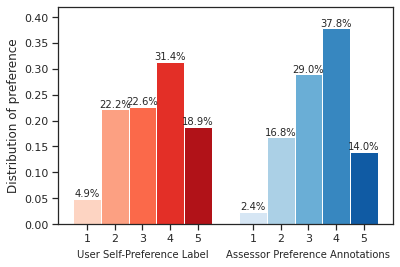

In [23]:
plot_dist_field([int(t) for t in df_item['post_expected_preference']], range(1, 6))
plot_dist_field(df_item['peer_preference'], range(1, 6), offset=6, colorgroup="Blues")
plt.ylim(0.0, 0.42)
plt.xticks(list(range(0, 5)) + list(range(6, 11)), list(range(1, 6)) + list(range(1, 6)))
plt.text(2, -0.065, "User Self-Preference Label", ha="center")
plt.text(8, -0.065, "Assessor Preference Annotations", ha="center")
plt.ylabel("Distribution of preference")
plt.savefig("figures/pref_dist.pdf", bbox_inches="tight")

# Figure 5

## Error distribution

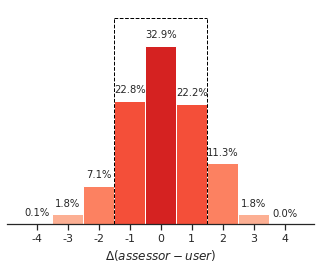

In [24]:
df_item['up_pref_diff'] = df_item['peer_preference'].map(lambda t: int(t)) - df_item['post_expected_preference'].map(lambda t: int(t))
def Ratio(values):
    cnt = Counter(values)
    n = len(values)
    ans = {}
    for k, v in cnt.items():
        ans[k] = v / float(n)
    return ans

def plot_dist_diff(dlist, vlist, label="", offset=0, color="r", colorgroup="Reds", center_value=0):
    cnt = Counter(dlist)
    dist_vec = np.array([cnt[t] for t in vlist], dtype=float)
    dist_vec = dist_vec / np.sum(dist_vec)
    with sns.color_palette(colorgroup, len(vlist) // 2 + 2) as tcolor:
        for ti, tv in enumerate(dist_vec):
            plt.bar(np.array([ti])+offset, [tv], width=1., label=str(ti+1), color=tcolor[ -2-int(abs(vlist[ti] - center_value)) ])
            # print (round(tv*100,1))
            plt.text(ti + offset, tv+0.02, "{}%".format(round(tv*100,1)), horizontalalignment='center', verticalalignment='center')
    # plt.legend()
    plt.xticks(np.arange(len(vlist)), vlist)

plt.figure(figsize=(5.5, 4))
ax = plt.subplot(111)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plot_dist_diff(df_item['up_pref_diff'], range(-4, 5))
# plt.text(0.5, 0.33, "#Assessor={}\nAgree.[-1:1]={}".format(1, round( 0.228+0.329+0.222 , 3)), color=red, ha="center", va="bottom")

plt.plot([2.5, 2.5], [0.0, 0.38], "--k", lw=1)
plt.plot([5.5, 5.5], [0.0, 0.38], "--k", lw=1)
plt.plot([2.5, 5.5], [0.38, 0.38], "--k", lw=1)
plt.ylim(0, 0.4)
# plt.ylabel("Distribution")
plt.yticks([])
plt.xlabel("$\Delta(assessor-user)$")
plt.savefig("figures/delta.pdf", bbox_inches="tight")

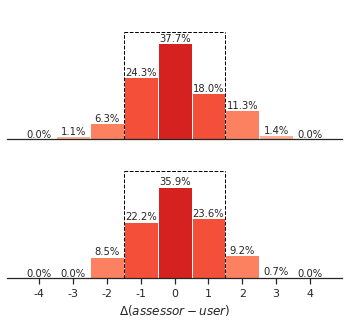

In [25]:
plt.figure(figsize=(6, 5))
for k in range(2, 4):
    up_diffs = []
    for (u, i), tdf in df_item.groupby(["user_id", "movie_id"]):
        upref = int(tdf.iloc[0,:][UPREF])
        apref = np.around(np.mean(tdf.iloc[:k][APREF]))
        up_diffs.append(apref - upref)
    
    ax = plt.subplot(2, 1, k-1)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plot_dist_diff(up_diffs, range(-4, 5))
    rto = Ratio(up_diffs)
    # plt.text(0.6, 0.4, "#Assessor={}\nAgree.[-1:1]={}".format(k, round( rto[-1] + rto[0] + rto[1] , 3)), color=red, ha="center", va="bottom")
    plt.ylim(0, 0.52)
    plt.plot([2.5, 2.5], [0.0, 0.42], "--k", lw=1)
    plt.plot([5.5, 5.5], [0.0, 0.42], "--k", lw=1)
    plt.plot([2.5, 5.5], [0.42, 0.42], "--k", lw=1)
    if k == 3:
        plt.xlabel("$\Delta(assessor-user)$")
    else:
        plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=0.05)
plt.savefig("figures/num_assess_agreement.pdf", bbox_inches="tight")

In [26]:
# aggregated
user_prefs = []
peer_prefs = []
for (u, i), tdf in df_item.groupby(["user_id", "movie_id"]):
    upref = int(tdf.iloc[0,:][UPREF])
    apref = np.around(np.mean(tdf[APREF])) # avg.
    user_prefs.append(upref)
    peer_prefs.append(apref)

# Table 2. line(-7): avg.
print ("alpha", alpha([user_prefs, peer_prefs], level_of_measurement="ordinal"))
print ("agree", sum(np.array(user_prefs) == np.array(peer_prefs)) / float(len(peer_prefs)))
print ("agree", sum(np.abs(np.array(user_prefs)- np.array(peer_prefs)) <= 1) / float(len(peer_prefs)))

alpha 0.3932994321143375
agree 0.3626760563380282
agree 0.8204225352112676


In [27]:
user_prefs = []
peer_prefs = []
for (u, i), tdf in df_item.groupby(["user_id", "movie_id"]):
    upref = 1 if int(tdf.iloc[0,:][UPREF]) > 3 else 0
    # apref = 1 if np.around(np.mean(tdf[APREF])) > 3 else 0 # avg.
    apref = Counter([1 if t > 3 else 0 for t in tdf[APREF]]).most_common()[0][0]
    user_prefs.append(upref)
    peer_prefs.append(apref)
    
# Table 2. line(-7) # majority
# print (user_prefs)
print ("alpha", alpha([user_prefs, peer_prefs], level_of_measurement="ordinal"))
print ("agree", sum(np.array(user_prefs) == np.array(peer_prefs)) / float(len(peer_prefs)))

alpha 0.28990539015710437
agree 0.6443661971830986


## Transition Matrix

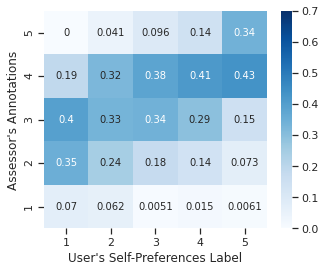

In [28]:
# transition matrix
plt.figure(figsize=(5, 4))
plot_change_mat("post_expected_preference", "peer_preference", df_item)
plt.xlabel("User's Self-Preferences Label")
plt.ylabel("Assessor's Annotations")
plt.savefig("figures/change_mat.pdf", bbox_inches="tight")

## Pairwise

In [29]:
def build_item_pairs_within_user(df_item, key="user_id", value="movie_id"):
    ans = []
    for u, tdf in df_item.groupby(key):
        for v1, v2 in combinations(set(tdf[value]), 2):
            if random.random() > 0.5:
                v1, v2 = v2, v1
            ans.append((u, v1, v2))
    return ans
random.seed(2021)
user_itempairs = build_item_pairs_within_user(df_item)

peer_ui_dic = {}
user_ui_dic = {}
for (u, i), tdf in df_item.groupby(by=['user_id', 'movie_id']):
    peer_ui_dic[(u, i)] = np.around(np.mean(tdf[APREF]))
    user_ui_dic[(u, i)] = int(tdf.iloc[0,:][UPREF])

pair_upref = []
pair_apref = []
for u, i1, i2 in user_itempairs:
    u1, u2 = user_ui_dic[(u, i1)], user_ui_dic[(u, i2)]
    pair_upref.append( 1 if u1 < u2 else 2 if u1 == u2 else 3 )
    
    p1, p2 = peer_ui_dic[(u, i1)], peer_ui_dic[(u, i2)]
    pair_apref.append( 1 if p1 < p2 else 2 if p1 == p2 else 3 )
    
print("Krippendorff's alpha:", round(alpha([pair_upref, pair_apref], level_of_measurement='ordinal'), 3))

# Table 2: pairwise.

Krippendorff's alpha: 0.426


In [30]:
# Concordance
pair_upref = np.array(pair_upref)
pair_apref = np.array(pair_apref)

idx = pair_upref > 0
sum(pair_upref[idx] == pair_apref[idx]) / float(len(pair_upref[idx]))

# Table 2: concordance

0.5111204364246748

In [31]:
# Concordance
pair_upref_filter = np.array([t for t in pair_upref if t != 2])
pair_apref_filter = np.array([a for u, a in zip(pair_upref, pair_apref) if u != 2])

idx = pair_upref_filter > 0
sum(pair_upref_filter[idx] == pair_apref_filter[idx]) / float(len(pair_upref_filter[idx]))

# Table 2: concordance

0.5387263339070568

In [32]:
def build_item_pairs_within_user(df_item, key="user_id", value="movie_id"):
    ans = []
    for u, tdf in df_item.groupby(key):
        for v1, v2 in combinations(set(tdf[value]), 2):
            if random.random() > 0.5:
                v1, v2 = v2, v1
            ans.append((u, v1, v2))
    return ans
random.seed(2021)
user_itempairs = build_item_pairs_within_user(df_item)

peer_ui_dic = {}
user_ui_dic = {}
for (u, i), tdf in df_item.groupby(by=['user_id', 'movie_id']):
    peer_ui_dic[(u, i)] = 1 if np.around(np.mean(tdf[APREF])) > 3 else 0
    user_ui_dic[(u, i)] = 1 if int(tdf.iloc[0,:][UPREF]) > 3 else 0

pair_upref = []
pair_apref = []
for u, i1, i2 in user_itempairs:
    u1, u2 = user_ui_dic[(u, i1)], user_ui_dic[(u, i2)]
    pair_upref.append( 1 if u1 < u2 else 2 if u1 == u2 else 3 )
    
    p1, p2 = peer_ui_dic[(u, i1)], peer_ui_dic[(u, i2)]
    pair_apref.append( 1 if p1 < p2 else 2 if p1 == p2 else 3 )
    
print("Krippendorff's alpha:", round(alpha([pair_upref, pair_apref], level_of_measurement='ordinal'), 3))

Krippendorff's alpha: 0.337


In [33]:
len(user_itempairs)

2383

In [34]:
# Concordance
pair_upref = np.array(pair_upref)
pair_apref = np.array(pair_apref)

idx = pair_upref > 0
sum(pair_upref[idx] == pair_apref[idx]) / float(len(pair_upref[idx]))

# Table 2: concordance

0.5115400755350399

In [35]:
# Concordance
pair_upref = np.array(pair_upref)
pair_apref = np.array(pair_apref)

idx = pair_upref != 2
sum(pair_upref[idx] == pair_apref[idx]) / float(len(pair_upref[idx]))

# Table 2: concordance

0.4424778761061947